# Quick Start Guide

In [1]:
import backtrader as bt
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import pandas_datareader.data as web

C:\Users\tbndo\Anaconda3\envs\build\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
class testStrategy(bt.Strategy):
    
    params = (
        ('maperiod', 20),
    )
    
    def log(self, txt, dt = None):
        # logging function fro the strategy
        dt = dt or self.getdatabyname('AMZN').datetime.date(0)
        print(f"{dt.isoformat()}, {txt}")
        
    def __init__(self):
        
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None   
    
        self.dataclose = self.getdatabyname('AMZN').close
        self.sma = bt.indicators.SimpleMovingAverage(self.getdatabyname('AMZN'), period = self.params.maperiod)
        
        
        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.getdatabyname('AMZN'), period=25)
        bt.indicators.WeightedMovingAverage(self.getdatabyname('AMZN'), period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.getdatabyname('AMZN'))
        bt.indicators.MACDHisto(self.getdatabyname('AMZN'))
        rsi = bt.indicators.RSI(self.getdatabyname('AMZN'))
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.getdatabyname('AMZN'), plot=False)
       
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # do nothing
            pass
    
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"BUY EXECUTED: {order.executed.price}, {order.executed.value}, {order.executed.comm}")
            elif order.issell():
                self.log(f"SELL EXECUTED: {order.executed.price}")
            self.bar_executed = len(self)
        elif order.status in [order.Cancelled, order.Margin, order.Rejected]:
            self.log(f"Order Cancelled, Margin, Rejected")
            
        # Write down: no pending order
        self.order = None
        
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        if self.order:
            return
        
        # if not in position
        if not self.position:
            # if our conditions are met
            if self.dataclose[0] > self.sma:
                # buy
                self.log(f"BUY CREATE: {self.dataclose[0]}")

                # keep track of the order to avoid making another one
                self.order = self.buy()
        
        # if in position, we might consider selling
        else:
            if self.dataclose[0] < self.sma:
                self.log(f"SELL CREATE: {self.dataclose[0]}")
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [3]:
cerebro = bt.Cerebro()

cerebro.addstrategy(testStrategy)

0

In [4]:
class PandasData(bt.feed.DataBase):
    params = (
        ('datetime', None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', None),
    )
    
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2016, 10, 31)
is_first = True
# Not the same set of symbols as in other blog posts
symbols = ["AAPL", "GOOG", "MSFT", "AMZN", "SNY", "NTDOY", "IBM", "HPQ", "QCOM", "NVDA"]
plot_symbols = ["AMZN"]
#plot_symbols = []
for s in symbols:
    data = web.DataReader(
            name = s,
            data_source = 'yahoo',
            start = '2010-01-01',
            end = '2016-10-31'  
        ).rename(
            columns = {
                'Open': 'open',
                'High': 'high',
                'Low': 'low',
                'Close': 'close',
                'Volume': 'volume'
            }
        )
    
    data = bt.feeds.PandasData(dataname = data, fromdate = start, todate = end)
    if s in plot_symbols:
        if is_first:
            data_main_plot = data
            is_first = False
        else:
            data.plotinfo.plotmaster = data_main_plot
    else:
        data.plotinfo.plot = False
    cerebro.adddata(data, name = s)    # Give the data to cerebro

In [5]:
# Set our desired cash start
cerebro.broker.setcash(100000.0)
# 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission = 0.001)

# add sizers
cerebro.addsizer(bt.sizers.FixedSize, stake = 10)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run(maxcpus=1)

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2010-02-22, Close, 118.01
2010-02-23, Close, 117.24
2010-02-24, Close, 119.72
2010-02-24, BUY CREATE: 119.72000122070312
2010-02-25, BUY EXECUTED: 28.1971435546875, 281.971435546875, 0.281971435546875
2010-02-25, Close, 118.20
2010-02-25, SELL CREATE: 118.19999694824219
2010-02-26, SELL EXECUTED: 28.911428451538086
2010-02-26, Close, 118.40
2010-02-26, BUY CREATE: 118.4000015258789
2010-03-01, BUY EXECUTED: 29.39285659790039, 293.9285659790039, 0.2939285659790039
2010-03-01, Close, 124.54
2010-03-02, Close, 125.53
2010-03-03, Close, 125.89
2010-03-04, Close, 128.53
2010-03-05, Close, 128.91
2010-03-08, Close, 130.11
2010-03-09, Close, 128.82
2010-03-10, Close, 130.51
2010-03-11, Close, 133.58
2010-03-12, Close, 131.82
2010-03-15, Close, 131.13
2010-03-16, Close, 131.79
2010-03-17, Close, 131.34
2010-03-18, Close, 132.76
2010-03-19, Close, 130.35
2010-03-22, Close, 130.47
2010-03-23, Close, 129.26
2010-03-24, Close, 128.04
2010-03-24, SELL CREATE: 128

2011-01-21, SELL EXECUTED: 47.681427001953125
2011-01-21, Close, 177.42
2011-01-24, Close, 176.85
2011-01-25, Close, 176.70
2011-01-26, Close, 175.39
2011-01-27, Close, 184.45
2011-01-27, BUY CREATE: 184.4499969482422
2011-01-28, BUY EXECUTED: 49.16714096069336, 491.6714096069336, 0.4916714096069336
2011-01-28, Close, 171.14
2011-01-28, SELL CREATE: 171.13999938964844
2011-01-31, SELL EXECUTED: 47.97142791748047
2011-01-31, Close, 169.64
2011-02-01, Close, 172.11
2011-02-02, Close, 173.53
2011-02-03, Close, 173.71
2011-02-04, Close, 175.93
2011-02-07, Close, 176.43
2011-02-08, Close, 183.06
2011-02-08, BUY CREATE: 183.05999755859375
2011-02-09, BUY EXECUTED: 50.74142837524414, 507.4142837524414, 0.5074142837524415
2011-02-09, Close, 185.30
2011-02-10, Close, 186.21
2011-02-11, Close, 189.25
2011-02-14, Close, 190.42
2011-02-15, Close, 189.03
2011-02-16, Close, 186.62
2011-02-17, Close, 187.76
2011-02-18, Close, 186.50
2011-02-22, Close, 180.42
2011-02-22, SELL CREATE: 180.4199981689453

2012-01-23, Close, 186.09
2012-01-24, Close, 187.00
2012-01-25, Close, 187.80
2012-01-26, Close, 193.32
2012-01-27, Close, 195.37
2012-01-30, Close, 192.15
2012-01-31, Close, 194.44
2012-02-01, Close, 179.46
2012-02-01, SELL CREATE: 179.4600067138672
2012-02-02, SELL EXECUTED: 65.12857055664062
2012-02-02, Close, 181.72
2012-02-03, Close, 187.68
2012-02-03, BUY CREATE: 187.67999267578125
2012-02-06, BUY EXECUTED: 65.48285675048828, 654.8285675048828, 0.6548285675048828
2012-02-06, Close, 183.14
2012-02-06, SELL CREATE: 183.13999938964844
2012-02-07, SELL EXECUTED: 66.46428680419922
2012-02-07, Close, 184.19
2012-02-08, Close, 185.48
2012-02-09, Close, 184.98
2012-02-10, Close, 185.54
2012-02-13, Close, 191.59
2012-02-13, BUY CREATE: 191.58999633789062
2012-02-14, BUY EXECUTED: 72.09428405761719, 720.9428405761719, 0.7209428405761719
2012-02-14, Close, 191.30
2012-02-15, Close, 184.47
2012-02-15, SELL CREATE: 184.47000122070312
2012-02-16, SELL EXECUTED: 70.21428680419922
2012-02-16, Cl

2013-03-04, Close, 273.11
2013-03-05, Close, 275.59
2013-03-06, Close, 273.79
2013-03-07, Close, 273.88
2013-03-08, Close, 274.19
2013-03-11, Close, 271.24
2013-03-12, Close, 274.13
2013-03-13, Close, 275.10
2013-03-14, Close, 265.74
2013-03-14, SELL CREATE: 265.739990234375
2013-03-15, SELL EXECUTED: 62.56142807006836
2013-03-15, Close, 261.82
2013-03-18, Close, 257.89
2013-03-19, Close, 256.41
2013-03-20, Close, 257.28
2013-03-21, Close, 253.39
2013-03-22, Close, 257.75
2013-03-25, Close, 256.02
2013-03-26, Close, 260.31
2013-03-27, Close, 265.30
2013-03-28, Close, 266.49
2013-03-28, BUY CREATE: 266.489990234375
2013-04-01, BUY EXECUTED: 63.128570556640625, 631.2857055664062, 0.6312857055664063
2013-04-01, Close, 261.61
2013-04-01, SELL CREATE: 261.6099853515625
2013-04-02, SELL EXECUTED: 61.08571243286133
2013-04-02, Close, 263.32
2013-04-03, Close, 259.03
2013-04-04, Close, 259.08
2013-04-05, Close, 255.48
2013-04-08, Close, 258.95
2013-04-09, Close, 261.14
2013-04-10, Close, 264.7

2014-02-26, Close, 359.80
2014-02-26, BUY CREATE: 359.79998779296875
2014-02-27, BUY EXECUTED: 73.87714385986328, 738.7714385986328, 0.7387714385986328
2014-02-27, Close, 360.13
2014-02-28, Close, 362.10
2014-03-03, Close, 359.78
2014-03-04, Close, 363.90
2014-03-05, Close, 372.37
2014-03-06, Close, 372.16
2014-03-07, Close, 372.06
2014-03-10, Close, 370.53
2014-03-11, Close, 368.82
2014-03-12, Close, 370.64
2014-03-13, Close, 371.51
2014-03-14, Close, 373.74
2014-03-17, Close, 375.04
2014-03-18, Close, 378.77
2014-03-19, Close, 373.23
2014-03-20, Close, 368.97
2014-03-21, Close, 360.62
2014-03-21, SELL CREATE: 360.6199951171875
2014-03-24, SELL EXECUTED: 76.91714477539062
2014-03-24, Close, 351.85
2014-03-25, Close, 354.71
2014-03-26, Close, 343.41
2014-03-27, Close, 338.47
2014-03-28, Close, 338.29
2014-03-31, Close, 336.37
2014-04-01, Close, 342.99
2014-04-02, Close, 341.96
2014-04-03, Close, 333.62
2014-04-04, Close, 323.00
2014-04-07, Close, 317.76
2014-04-08, Close, 327.07
2014-0

2015-03-24, SELL EXECUTED: 127.2300033569336
2015-03-24, Close, 374.09
2015-03-25, Close, 370.96
2015-03-26, Close, 367.35
2015-03-27, Close, 370.56
2015-03-30, Close, 374.59
2015-03-31, Close, 372.10
2015-04-01, Close, 370.26
2015-04-02, Close, 372.25
2015-04-06, Close, 377.04
2015-04-06, BUY CREATE: 377.0400085449219
2015-04-07, BUY EXECUTED: 127.63999938964844, 1276.3999938964844, 1.2763999938964845
2015-04-07, Close, 374.41
2015-04-08, Close, 381.20
2015-04-09, Close, 383.54
2015-04-10, Close, 382.65
2015-04-13, Close, 382.36
2015-04-14, Close, 385.11
2015-04-15, Close, 383.45
2015-04-16, Close, 386.04
2015-04-17, Close, 375.56
2015-04-17, SELL CREATE: 375.55999755859375
2015-04-20, SELL EXECUTED: 125.56999969482422
2015-04-20, Close, 389.51
2015-04-20, BUY CREATE: 389.510009765625
2015-04-21, BUY EXECUTED: 128.10000610351562, 1281.0000610351562, 1.2810000610351562
2015-04-21, Close, 391.18
2015-04-22, Close, 389.80
2015-04-23, Close, 389.99
2015-04-24, Close, 445.10
2015-04-27, Cl

2016-05-10, Close, 703.07
2016-05-11, Close, 713.23
2016-05-12, Close, 717.93
2016-05-13, Close, 709.92
2016-05-16, Close, 710.66
2016-05-17, Close, 695.27
2016-05-18, Close, 697.45
2016-05-19, Close, 698.52
2016-05-20, Close, 702.80
2016-05-23, Close, 696.75
2016-05-24, Close, 704.20
2016-05-25, Close, 708.35
2016-05-26, Close, 714.91
2016-05-27, Close, 712.24
2016-05-31, Close, 722.79
2016-06-01, Close, 719.44
2016-06-02, Close, 728.24
2016-06-03, Close, 725.54
2016-06-06, Close, 726.73
2016-06-07, Close, 723.74
2016-06-08, Close, 726.64
2016-06-09, Close, 727.65
2016-06-10, Close, 717.91
2016-06-13, Close, 715.24
2016-06-14, Close, 719.30
2016-06-15, Close, 714.26
2016-06-15, SELL CREATE: 714.260009765625
2016-06-16, SELL EXECUTED: 96.44999694824219
2016-06-16, Close, 717.51
2016-06-16, BUY CREATE: 717.510009765625
2016-06-17, BUY EXECUTED: 96.62000274658203, 966.2000274658203, 0.9662000274658203
2016-06-17, Close, 706.39
2016-06-17, SELL CREATE: 706.3900146484375
2016-06-20, SELL E

<IPython.core.display.Javascript object>


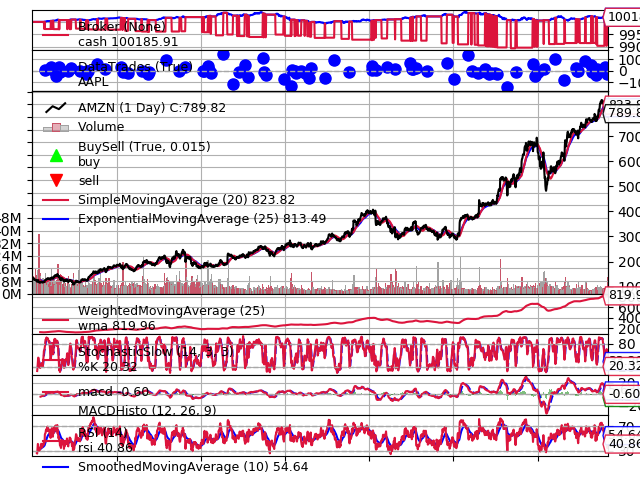

[[<Figure size 640x480 with 8 Axes>]]

In [6]:
cerebro.plot()

# Concepts

## Platform Concepts

In [7]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds

In [8]:
import pandas as pd

In [9]:
data = cerebro.datasbyname['AAPL']

In [10]:
window = 300
lookback = 60

In [11]:
len(list(range(0, window)))

300

In [12]:
prices = pd.Series(data.get(0, window + 1 + lookback))
returns = prices.pct_change(periods = 1)
returns

0           NaN
1      0.001996
2     -0.004443
3      0.001231
4     -0.005841
         ...   
356    0.005100
357   -0.022495
358   -0.009603
359   -0.006639
360   -0.001583
Length: 361, dtype: float64

In [13]:
train_data = pd.DataFrame()
for i in range(0, lookback + 1):
    series = returns.shift(periods = i)
    series.name = f"lag_{i}"
    train_data = pd.concat([train_data, series], axis = 1)

In [14]:
train_data = train_data.dropna().iloc[:window]
train_data

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60
61,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,-0.000781,0.015420,...,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841,0.001231,-0.004443,0.001996
62,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,-0.000781,...,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841,0.001231,-0.004443
63,0.029447,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,...,0.005358,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841,0.001231
64,0.003277,0.029447,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,...,-0.002351,0.005358,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841
65,-0.004678,0.003277,0.029447,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,...,0.004556,-0.002351,0.005358,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,-0.003068,0.008942,...,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538,-0.014804,0.017657
357,-0.022495,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,-0.003068,...,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538,-0.014804
358,-0.009603,-0.022495,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,...,-0.000913,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538
359,-0.006639,-0.009603,-0.022495,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,...,-0.001463,-0.000913,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756


In [15]:
X = train_data.iloc[:, 1:]
X

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60
61,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,-0.000781,0.015420,-0.052038,...,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841,0.001231,-0.004443,0.001996
62,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,-0.000781,0.015420,...,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841,0.001231,-0.004443
63,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,-0.000781,...,0.005358,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841,0.001231
64,0.029447,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,...,-0.002351,0.005358,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841
65,0.003277,0.029447,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,...,0.004556,-0.002351,0.005358,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,-0.003068,0.008942,0.002154,...,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538,-0.014804,0.017657
357,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,-0.003068,0.008942,...,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538,-0.014804
358,-0.022495,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,-0.003068,...,-0.000913,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538
359,-0.009603,-0.022495,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,...,-0.001463,-0.000913,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756


In [16]:
y = train_data.loc[:, 'lag_0']
y = pd.Series(np.where(y > 0, 1, 0))
y

0      1
1      1
2      1
3      1
4      0
      ..
295    1
296    0
297    0
298    0
299    0
Length: 300, dtype: int32

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [19]:
clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
example = np.array(train_data.iloc[window - 1, ][:-1]).reshape(1, -1)
# pd.Series(example[0])

In [22]:
prediction = clf.predict(example)
prediction

array([1])

In [58]:
window, lookback

(300, 60)

In [80]:
raw_prices = data.get(size = window + 1 + lookback) #
prices = np.array(raw_prices)

returns = pd.Series(prices).pct_change(periods = 1)
returns

0           NaN
1      0.001996
2     -0.004443
3      0.001231
4     -0.005841
         ...   
356    0.005100
357   -0.022495
358   -0.009603
359   -0.006639
360   -0.001583
Length: 361, dtype: float64

In [81]:
train_data = pd.DataFrame()
for i in range(0, lookback + 1):
    series = returns.shift(periods = i)
    series.name = f"lag_{i}"
    train_data = pd.concat([train_data, series], axis = 1)

In [82]:
train_data

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.001996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.004443,0.001996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.001231,-0.004443,0.001996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.005841,0.001231,-0.004443,0.001996,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,-0.003068,0.008942,...,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538,-0.014804,0.017657
357,-0.022495,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,-0.003068,...,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538,-0.014804
358,-0.009603,-0.022495,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,...,-0.000913,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538
359,-0.006639,-0.009603,-0.022495,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,...,-0.001463,-0.000913,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756


In [83]:
train_data = train_data.dropna().iloc[:window]

In [84]:
train_data

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60
61,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,-0.000781,0.015420,...,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841,0.001231,-0.004443,0.001996
62,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,-0.000781,...,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841,0.001231,-0.004443
63,0.029447,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,...,0.005358,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841,0.001231
64,0.003277,0.029447,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,...,-0.002351,0.005358,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841
65,-0.004678,0.003277,0.029447,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,...,0.004556,-0.002351,0.005358,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,-0.003068,0.008942,...,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538,-0.014804,0.017657
357,-0.022495,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,-0.003068,...,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538,-0.014804
358,-0.009603,-0.022495,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,...,-0.000913,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538
359,-0.006639,-0.009603,-0.022495,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,...,-0.001463,-0.000913,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756


In [85]:
X = train_data.iloc[:, 1:]
y = train_data.loc[:, 'lag_0']
y = pd.Series(np.where(y > 0, 1, 0))

In [86]:
X

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60
61,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,-0.000781,0.015420,-0.052038,...,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841,0.001231,-0.004443,0.001996
62,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,-0.000781,0.015420,...,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841,0.001231,-0.004443
63,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,-0.000781,...,0.005358,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841,0.001231
64,0.029447,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,0.007034,...,-0.002351,0.005358,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489,-0.005841
65,0.003277,0.029447,0.057355,0.006012,-0.024962,-0.061163,-0.020520,-0.012790,-0.005633,0.010348,...,0.004556,-0.002351,0.005358,-0.001966,-0.011043,-0.002250,0.011458,-0.002973,-0.006607,-0.005489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,-0.003068,0.008942,0.002154,...,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538,-0.014804,0.017657
357,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,-0.003068,0.008942,...,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538,-0.014804
358,-0.022495,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,-0.003068,...,-0.000913,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756,0.012538
359,-0.009603,-0.022495,0.005100,0.009005,-0.003930,-0.000512,-0.002979,-0.000681,-0.000680,0.005556,...,-0.001463,-0.000913,0.012017,0.002316,-0.000648,-0.007444,0.004060,0.008281,0.015207,0.000756


In [87]:
y

0      1
1      1
2      1
3      1
4      0
      ..
295    1
296    0
297    0
298    0
299    0
Length: 300, dtype: int32

In [88]:
print(X)
print(y)

        lag_1     lag_2     lag_3     lag_4     lag_5     lag_6     lag_7  \
61  -0.024962 -0.061163 -0.020520 -0.012790 -0.005633  0.010348  0.007034   
62   0.006012 -0.024962 -0.061163 -0.020520 -0.012790 -0.005633  0.010348   
63   0.057355  0.006012 -0.024962 -0.061163 -0.020520 -0.012790 -0.005633   
64   0.029447  0.057355  0.006012 -0.024962 -0.061163 -0.020520 -0.012790   
65   0.003277  0.029447  0.057355  0.006012 -0.024962 -0.061163 -0.020520   
..        ...       ...       ...       ...       ...       ...       ...   
356  0.009005 -0.003930 -0.000512 -0.002979 -0.000681 -0.000680  0.005556   
357  0.005100  0.009005 -0.003930 -0.000512 -0.002979 -0.000681 -0.000680   
358 -0.022495  0.005100  0.009005 -0.003930 -0.000512 -0.002979 -0.000681   
359 -0.009603 -0.022495  0.005100  0.009005 -0.003930 -0.000512 -0.002979   
360 -0.006639 -0.009603 -0.022495  0.005100  0.009005 -0.003930 -0.000512   

        lag_8     lag_9    lag_10  ...    lag_51    lag_52    lag_53  \
61 

In [89]:
X.values

array([[-0.02496217, -0.06116289, -0.02051996, ...,  0.00123106,
        -0.00444298,  0.00199566],
       [ 0.00601237, -0.02496217, -0.06116289, ..., -0.00584072,
         0.00123106, -0.00444298],
       [ 0.05735497,  0.00601237, -0.02496217, ..., -0.00548861,
        -0.00584072,  0.00123106],
       ...,
       [-0.02249475,  0.00509986,  0.00900517, ...,  0.01520734,
         0.00075623,  0.01253826],
       [-0.00960285, -0.02249475,  0.00509986, ...,  0.0082806 ,
         0.01520734,  0.00075623],
       [-0.00663873, -0.00960285, -0.02249475, ...,  0.00406012,
         0.0082806 ,  0.01520734]])

In [90]:
y.values.reshape(-1, 1)

array([[1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
    

In [91]:
clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [93]:
inputt = np.array(train_data.iloc[window - 1, ][:-1]).reshape(1, -1)
prediction = clf.predict(inputt)
prediction

array([1])